# Uncertainty in drought indicators in the ERA5–Drought dataset

Production date: 2026-02-xx

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Dataset version: 1.0.

Produced by: Enis Gerxhalija, Olivier Burggraaff (National Physical Laboratory).

## 🌍 Use case: Use case listed here in full 

## ❓ Quality assessment question
* **In most cases there should be one question listed here in bold**
* **(In some cases a second related/follow-up question may be included)**

**‘Context paragraph’ (no title/heading)** - a very short introduction before the assessment statement describing approach taken to answer the user question. One or two key references could be useful,  if the assessment summarises literature . These can be referenced directly in the text, like `[Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2)` giving: [Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2). For major references numerical labels like this should be used (which should also listed at the end) `Rodriguez et. al. 2018, [[1]](https://doi.org/10.1038/s41598-018-20628-2))`giving: Rodriguez et. al. 2018, [[1]](https://doi.org/10.1038/s41598-018-20628-2)). Please use DOI links where possible.


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology

A ‘free text’ introduction to the data analysis steps or a description of the literature synthesis, with a justification of the approach taken, and limitations mentioned. **Mention which CDS catalogue entry is used, including a link, and also any other entries used for the assessment**.

Followed by a numbered list of the methodology and results, with the same headings as the sections under ‘Analysis and Results’. These should be links to the sections below, using the format `[](section-label)`. The title of the section will be automatically populated, so no need to repeat the title of the section when referecing it like this.

```{note}
The section labels for the links need to be manually set, as seen below (`(section-1)=`, followed by the heading). These labels will be shown in GitHub but will not appear when the Jupyter Book page is built.
```

* These headings can be specific to the quality assessment, and help guide the user through the ‘story’ of the assessment. This means we cannot pre-define the sections and headings here, as they will be different for each assessment.
* Sub-bullets could be used to outline what will be done/shown/discussed in each section
* The list below is just an example, or may need more or fewer sections, with different headings

E.g. 'The analysis and results are organised in the following steps, which are detailed in the sections below:' 

**[](section-codesetup)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-spi)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

<!-- **[](section-spei)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-4)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.
 
**[](section-5)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings. -->

Any further notes on the method could go here (explanations, caveats or limitations).

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data. Because earthkit is in active development, some functionality may change after this notebook is published. If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [1]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd
import warnings

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial

# Analysis
import calendar
from scipy import stats

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

# Type hints
from typing import Callable, Iterable, Optional
from scipy.stats import rv_continuous as Distribution
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

#### Helper functions
This section defines some functions and variables used in the following analysis, allowing code cells in later sections to be shorter and ensuring consistency.

##### Data (pre-)processing

The following functions restructure the ensemble members in the ERA5–Drought dataset along a new dimension, as in ERA5:

In [2]:
def add_number_dimension(data: xr.Dataset, *, n_members: int=10,
                         time_dimension: str="time", ensemble_dimension: str="number") -> xr.Dataset:
    """
    Convert a dataset
    from ERA5–Drought format (10-duplicate `time` dimension)
    to ERA5 format (`number` dimension for ensemble members)
    """
    # Find unique times and use these to generate datasets for successive members
    member_numbers = np.arange(n_members)
    _, index = np.unique(data[time_dimension], return_index=True)
    data = [data.isel({time_dimension: index + i}) for i in member_numbers]

    # Combine into one dataset
    data = xr.concat(data, dim=ensemble_dimension).assign_coords(number=member_numbers)

    # Rechunk for memory efficiency
    data = data.chunk({ensemble_dimension: n_members, time_dimension: 48, "lat": 360, "lon": 103,})

    return data

##### Accumulation periods
The following cells contain constants and functions used in accumulating variables (e.g. precipitation) over time:

In [3]:
# Define constants such as the accumulation periods to use
ACCUMULATION_PERIODS = [1, 3, 6, 12, 24, 36, 48]  # Months
MONTHS = range(1, 13)  # January to December (inclusive)

##### Statistics
The following ...

In [4]:
def ensemble_mean_and_spread(data: xr.Dataset, *, number_dim: str="number") -> tuple[xr.Dataset, xr.Dataset]:
    """ Calculate the mean and spread within an ensemble along the number dimension. """
    # Calculate mean
    mean = data.mean(number_dim)

    # Calculate spread
    spread = data.std(number_dim)

    return mean, spread

In [5]:
def _digitise_dataset(data: xr.Dataset, bin_edges: list[float], *, persist=True) -> xr.Dataset:
    """
    Digitise all variables in `data` according to a list of left bin edges, e.g. SPI categories ("extremely dry").
    In this notebook, do not call this function directly, but use the categorise_dataset wrapper.
    """
    
    # Perform digitisation
    data_digitised = xr.apply_ufunc(np.digitize, data,
                                    kwargs={"bins": bin_edges, "right": False}, 
                                    input_core_dims=[[]],
                                    vectorize=True, dask="parallelized",
                                    output_dtypes=[np.uint8],  # uint8 is small; not suitable for >256 categories
    )

    # Persist in memory if desired (default True because uint8s are small)
    if persist:
        data_digitised = data_digitised.persist()
    
    return data_digitised

def categorise_dataset(data: xr.Dataset, categories: Iterable[Iterable], **kwargs) -> xr.Dataset:
    """
    Categorise a dataset into bins defined by category thresholds.
    Extracts bin edges from `categories` and then digitises `data` accordingly.
    Handles NaNs by adding a dummy category (extremely high bin edge).
    """
    # Extract bin edges from categories
    # Last element is dropped to extend range to infinity (although values should be clipped anyway)
    bin_edges = [category[0] for category in categories[:-1]]

    # Add dummy category to catch NaNs
    bin_edges = [100000] + bin_edges

    # Apply digitisation
    data_categorised = _digitise_dataset(data, bin_edges, **kwargs)

    return data_categorised

##### Visualisation
The following cells contain functions for plotting results, starting with some base helper functions (e.g. displaying in Jupyter Notebook or Jupyter Book style, adding textboxes with consistent formatting, etc.):

In [6]:
_style_spi =        {"cmap": plt.cm.RdBu,    "vmin": -3, "vmax": 3,   "extend": "both"}
_style_spi_spread = {"cmap": plt.cm.cividis, "vmin": 0,  "vmax": 1.5, "extend": "max"}

styles = {
    "SPI_mean": Style(**_style_spi), "SPI_spread": Style(**_style_spi_spread),
}

# Apply general settings
for style in styles.values():
    style.normalize = False

In [41]:
def decorate_fig(fig: ekp.Figure, *, title: Optional[str]="") -> None:
    """ Decorate an earthkit figure with land, coastlines, etc. """
    # Add progress bar because individual steps can be very slow for large plots
    with tqdm(total=4, desc="Decorating", leave=False) as progressbar:
        fig.land()
        progressbar.update()
        fig.coastlines()
        progressbar.update()
        # fig.borders()
        # progressbar.update()
        fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
        progressbar.update()
        fig.title(title)
        progressbar.update()

In [7]:
def plot_stacked(ax, df, ylabel):
    bottom = np.zeros(len(df.index))
    handles = []

    for i, sev in enumerate(severities):
        bar = ax.bar(
            df.index, df.iloc[:, i],
            facecolor=mycollisthex[i + 1],
            alpha=1,
            width=relativedelta.relativedelta(months=1),
            label=sev,
            bottom=bottom,
            align='edge'
        )
        handles.append(bar)
        bottom += df.iloc[:, i]

    # Axis formatting
    ax.set_ylabel(ylabel, size=11)
    ax.margins(x=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', colors='dimgrey')
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=10)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='lightgray', linestyle='solid', linewidth=0.8)
    ax.set_ylim([0, 100])

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    return handles

def plot_ens_index_timeseries(dataarray, title="SPI12 — time series for each ensemble member"):
    """
    Plot a time series of SPI (or any variable) for each ensemble member.
    """

    plt.figure(figsize=(12, 6))

    dataarray.plot.line(
        x='time',
        hue='number',
        add_legend=True,
        figsize=(12, 5),
    )

    # Custom styling
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(str(dataarray.name))  # use variable name dynamically
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The following cell contains functions for geospatial plots:

In [42]:
def geospatial_plot_mean_spread(data_mean: xr.Dataset, data_spread: xr.Dataset, indicator: str, date: str, *,
                                domain: Optional[AnyDomain]=None,
                                glue_label: Optional[str]=None) -> ekp.Figure:                   
    """
    Plot the mean and spread (pre-calculated) of an ensemble at a given time geospatially.
    """
    # Select data
    data_mean_spread = [data.sel({"time": date}) for data in (data_mean, data_spread)]

    # Determine if SPI or SPEI
    spi_or_spei = "SPEI" if "E" in indicator else "SPI"

    # Create figure
    fig = ekp.Figure(rows=1, columns=2, size=(8, 4))

    # Plot data
    for data, stat in zip(data_mean_spread, ["mean", "spread"]):
        # Plot data
        subplot = fig.add_map(domain=domain)
        subplot.grid_cells(data, style=styles[f"{spi_or_spei}_{stat}"])

        # Colour bar
        subplot.legend(location="bottom", label=f"{indicator} ({stat})")

    # Decorate figures
    decorate_fig(fig)
    fig.title(f"ERA5–Drought ensemble statistics on {date} in {domain}")
    
    # Show result
    plt.show()
    plt.close()

import geopandas as gpd
import regionmask

EARTHRADIUS = 6371  # earth radius [km]
def calculate_gridarea(lats_centr, res, nlon):

    lats1 = (lats_centr + (res / 2)) * np.pi / 180  # np.sin requires radians
    lats2 = (lats_centr - (res / 2)) * np.pi / 180
    areas = (
        (np.pi / 180) * (EARTHRADIUS ** 2) * np.abs(np.sin(lats1) - np.sin(lats2)) * res
    )

    ## overwrite any areas of 0 (at the poles) with np.NaN to prevent problems
    areas[np.where(areas == 0.0)] = np.nan  
    # return array of dimension nlat x nlon
    area_2d = np.swapaxes(np.tile(areas, (nlon, 1)), 0, 1)
    return area_2d
    
def rename_era5_dimensions(data: xr.Dataset) -> xr.Dataset:
    """
    Rename dimensions
    from ERA5 (valid_time, latitude, longitude)
    to ERA5–Drought (time, lat, lon)
    format.
    """
    data = data.rename({"valid_time": "time",
                        "latitude": "lat",
                        "longitude": "lon",
                       })
    return data

def longitude_360_to_180(data: xr.Dataset, longitude_dimension="lon") -> xr.Dataset:
    """ Convert longitude from 0..360 to -180..180 format. """
    longitude_new = ((data[longitude_dimension] - 180) % 360) - 180
    data = data.assign_coords({longitude_dimension: longitude_new})
    data = data.sortby(longitude_dimension)#.squeeze()
    return data

In [9]:
ID_ERA5_LANDSEAMASK = "reanalysis-era5-single-levels"

request_landsea_mask = {
    "product_type": "reanalysis",
    "variable": "land_sea_mask",
    "date": "2000-01-01",  # Does nothing but is required in CDS form
    "time": "00:00",       # Does nothing but is required in CDS form
    "format": "netcdf",
    "download_format": "zip",
}

# Download mask
LAND = ekd.from_source("cds", ID_ERA5_LANDSEAMASK, request_landsea_mask)
LAND = LAND.to_xarray(compat="equals")  # Convert to xarray dataset

# Convert longitude from 0..360 to –180..180
LAND = rename_era5_dimensions(LAND)
LAND_FRAC = longitude_360_to_180(LAND, "lon")

# Drop time dimension
LAND_FRAC = LAND_FRAC.squeeze("time")

# Convert to boolean mask: Land if > 0.5 (following ERA5 convention)
LAND = (LAND_FRAC["lsm"] > 0.5) # Land considered to be full

(section-spi)=
### 2. The ERA5–Drought ensemble: SPI & SPEI

#### Download data 
_In this assessment,
we will calculate SPI and SPEI for each month
(with different accumulation periods, see below)
for the years 1940–2024._
For the reference period,
we will use the World Meteorological Organization (WMO) current standard 30-year reference period of 1991–2020,
which is also used in ERA5–Drought.
Both of these date ranges can be adjusted in the cell below when running the analysis yourself:

In [10]:
# Define your preferred analysis and reference periods
years           = (1940, 2024)  # Years for the analysis (inclusive)
years_reference = (1991, 2020)  # Years for the reference period (inclusive)

Having defined our target years, we can now define our CDS request.
First, we define templates with some default parameters
(e.g. years, data format)
that will also be used later in the notebook.
Additional information for specific downloads
(e.g. variable, data stream)
is mixed into this template where relevant.

This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.
If you prefer not to use earthkit, the following requests can also be used with the [cdsapi module](https://cds.climate.copernicus.eu/how-to-api#linux-use-client-step).
In either case (earthkit-data or cdsapi), it is required to set up a CDS account and API key as explained [on the CDS website](https://cds.climate.copernicus.eu/how-to-api).

In [11]:
ID_ERA5_DROUGHT = "derived-drought-historical-monthly"

# Main template
request_era5drought_template = {
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "year": [f"{year}" for year in range(years[0], years[1]+1)],
    "month": [f"{month:02}" for month in MONTHS],
    "area": [-5, 109, -45, 159],
}
# ---- Components by product type ----
PRODUCT_REANALYSIS = {"product_type": ["reanalysis"]}
PRODUCT_ENSEMBLE   = {"product_type": ["ensemble_members"]}

# ---- Request by product type ----=
request_era5drought_reanalysis = PRODUCT_REANALYSIS | request_era5drought_template
request_era5drought_ensemble   = PRODUCT_ENSEMBLE   | request_era5drought_template

VARS      = ["standardised_precipitation_index", "standardised_precipitation_evapotranspiration_index"] 
# TODO: Fix overwriting by SPEI significance.

FLAG_VARS      = ["test_for_normality_spi", "probability_of_zero_precipitation_spi"] # TODO: Fix overwriting by SPEI significance.


# ---- Components by accumulation period ----
ACC_1  = {"accumulation_period": ["1"]}
ACC_12 = {"accumulation_period": ["12"]}

subrequests_ens_12 = [request_era5drought_ensemble | ACC_12 | {'variable': [var]} for var in VARS]
subrequests_ens_1 = [request_era5drought_ensemble | ACC_1 | {'variable': [var]} for var in VARS] # Build subrequests for ensemble product

subrequests_ens_flag_12 = [request_era5drought_ensemble | ACC_12 | {'variable': [var]} for var in FLAG_VARS]
subrequests_ens_flag_1 = [request_era5drought_ensemble | ACC_1 | {'variable': [var]} for var in FLAG_VARS] # Build subrequests for ensemble product

Unlike ERA5, ERA5–Drought does not come with a `number` dimension representing the ensemble members.
Instead, they are accessible via the `time` dimension, which has 10 entries (representing the 10 members) at each point in time.
For convience, we re-organise the dataset to include a `number` dimension:

In [31]:
def ens_drought_request(ekd_request):
    """ Take multiple accumulation period request for ensemble data and combine into one dataset. """
    file_paths = [fld.path for fld in ekd_request._indexes] # Extract file paths from the Earthkit FieldList
    datasets = [xr.open_dataset(path) for path in file_paths] # Open each file as xarray
    processed = [add_number_dimension(ds) for ds in datasets] #  Add the number dimension to each dataset
    final = xr.combine_by_coords(processed, join = "outer", combine_attrs="drop") # Stack all datasets together
    final = final.chunk({"time": -1}) # Rechunk to single time dimension
    return final 

def load_era5drought_data(subrequests_era5drought):
    """
    Retrieve ERA5 Drought data from CDS via Earthkit,
    convert to xarray, and add the 'number' dimension.
    """
    ds = ekd.from_source("cds", ID_ERA5_DROUGHT, *subrequests_era5drought)
    ds = ens_drought_request(ds)

    # ds = ds.to_xarray(compat="equals")
    # ds = add_number_dimension(ds)
    # ds = ds.chunk({"time": -1})  # Full time series in one chunk
    return ds

def apply_quality_mask(sig, index_ds):

    # 12‑month mask -> month dimension
    sig_m = sig.assign_coords(
        month=("time", sig.time.dt.month.values)
    ).swap_dims({"time": "month"}).drop_vars("time")

    # add month to long dataset
    index_ds = index_ds.assign_coords(
        month=index_ds.time.dt.month
    )

    # broadcast mask
    mask_full = sig_m.sel(month=index_ds.month)

    # apply
    return index_ds.where(mask_full == 1)
  

In [13]:
ds_ens_12 = load_era5drought_data(subrequests_ens_12)
ds_flag_ens_12 = load_era5drought_data(subrequests_ens_flag_12)

ds_ens_1 = load_era5drought_data(subrequests_ens_1)
ds_flag_ens_1 = load_era5drought_data(subrequests_ens_flag_1)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
sig_spi12 = xr.where(ds_flag_ens_12['significance'] == 1, 1, 0)
p0_spi12  = xr.where(ds_flag_ens_12['pzero'] <= 0.33, 1, 0)
sig_spi1 = xr.where(ds_flag_ens_12['significance'] == 1, 1, 0)
p0_spi1  = xr.where(ds_flag_ens_12['pzero'] <= 0.33, 1, 0) # set flag xarrays

spi12 = ds_ens_12["SPI12"]
spi1 = ds_ens_1["SPI1"]

In [29]:
sig = sig_spi12.assign_coords(
        month=("time", sig_spi12.time.dt.month.values)
    )

In [37]:
spi12_sig_masked = apply_quality_mask(sig_spi12, spi12) # significance masking
spi1_sig_masked = apply_quality_mask(sig_spi1, spi1) # significance masking

In [38]:
spi12_masked = apply_quality_mask(p0_spi12, spi12_sig_masked) # final masking 
spi1_masked = apply_quality_mask(p0_spi1, spi1_sig_masked) # final masking 

In [39]:
era5drought_ensemble_spi_mean_12, era5drought_ensemble_spi_spread_12 = ensemble_mean_and_spread(spi12_masked)
era5drought_ensemble_spi_mean_1, era5drought_ensemble_spi_spread_1 = ensemble_mean_and_spread(spi1_masked)

/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/dask/array/numpy_compat.py:61: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
                                                                                                                        

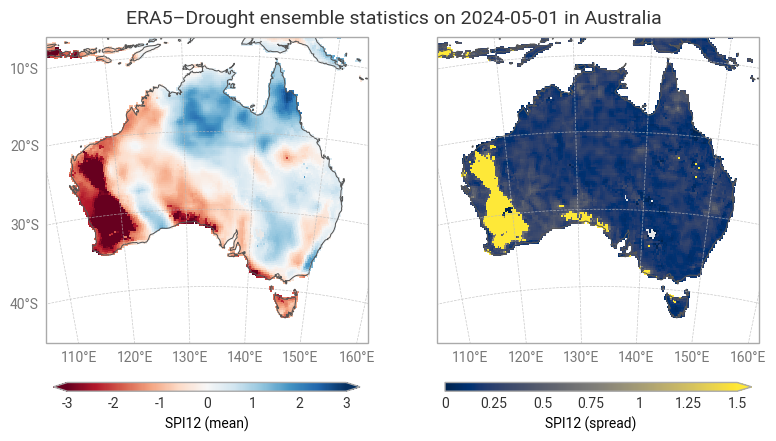

In [43]:
geospatial_plot_mean_spread(era5drought_ensemble_spi_mean_12, era5drought_ensemble_spi_spread_12, "SPI12", "2024-05-01",
                            domain="Australia")

/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/dask/array/numpy_compat.py:61: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
                                                                                                                        

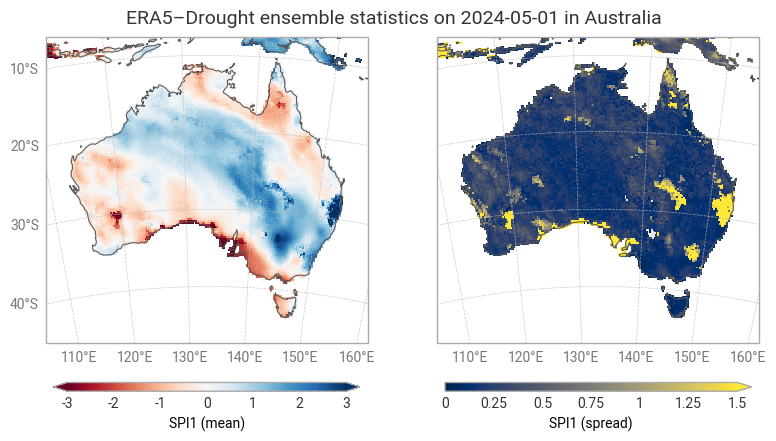

In [44]:
geospatial_plot_mean_spread(era5drought_ensemble_spi_mean_1, era5drought_ensemble_spi_spread_1, "SPI1", "2024-05-01",
                            domain="Australia")

Below, we define location of interest (Tibooburra, New South Wales, Australia)

In [45]:
example_site = {"lat": -29.25, "lon": 142.00}  # Compatible with ERA5–Drought.

Along with a list for categorising SPI/SPEI indices.

In [46]:
CATEGORIES_SPI = [  # Approximates the GDO scheme
    (   2.00, 100,     "Extremely wet",            "#7a007b"),  # deepest purple 
    (   1.50,   2.00,  "Severely wet",             "#af51c3"),  # dark purple
    (   1.00,   1.50,  "Moderately wet",           "#eaccf8"),  # medium purple
    (   0.00,   1.00,  "Near‑normal / mildly wet", "#ffffff"),  # white
    (  -1.00,   0.00,  "Near‑normal / mildly dry", "#ffffff"),  # white
    (  -1.50,  -1.00,  "Moderately dry",           "#fffc03"),  # yellow
    (  -2.00,  -1.50,  "Severely dry",             "#feaa00"),  # orange
    (-100,     -2.00,  "Extremely dry",            "#ff0100"),  # red
]
CATEGORIES_SPEI = [
    (   2.33, 100,    "Extremely wet",  "#01148b"),  # very dark navy
    (   1.65,   2.33, "Severely wet",   "#1871de"),  # strong blue
    (   1.28,   1.65, "Moderately wet", "#14acf4"),  # medium blue
    (   0.84,   1.28, "Mildly wet",     "#00f2fe"),  # cyan
    (  -0.84,   0.84, "Near-normal",    "#9afa93"),  # light green
    (  -1.28,  -0.84, "Mildly dry",     "#fdc403"),  # yellow
    (  -1.65,  -1.28, "Moderately dry", "#f2631d"),  # orange
    (  -2.33,  -1.65, "Severely dry",   "#df2929"),  # red
    (-100,     -2.33, "Extremely dry",  "#8c1b1a"),  # dark red
]

Code under this cell needs to be adapted still.

#### Ensemble SPI time series in example site (Tibooburra, New South Wales, Australia).

In [ ]:
da = spi12_masked.sel(**example_site)  # select the DataArray for SPI12.

plot_ens_index_timeseries(da)

Next we categorise each ensemble member in the SPI time series for the example site.

In [73]:
da_cat = categorise_dataset(da, CATEGORIES_SPI) # categorise each ensemble member.

And obtain a time series of how often each ensemble falls into each drought-severity category.

In [74]:
def get_unique_counts_per_timestamp(da_cat):
    """Return unique values and counts of category per column (timestamp)."""
    unique_vals = []
    counts_per_timestamp = []
    
    for col in da_cat.T:  # iterate over columns (timestamps)
        vals, counts = np.unique(col, return_counts=True)
        unique_vals.append(vals)
        counts_per_timestamp.append(counts)
    return unique_vals, counts_per_timestamp

unique_vals, counts_per_timestamp = get_unique_counts_per_timestamp(da_cat)

Next we filter the counts so we only look at dry event (defined as moderately dry or higher).

In [79]:
def get_filtered_counts_per_timestamp(counts_per_timestamp, unique_vals, threshold = 6):
    """Return categories of interest and  and counts of category per column (timestamp)."""

    filtered_counts = []
    filtered_cats = []

    for c_count, c_cat in zip(counts_per_timestamp, unique_vals):
        idx = np.where(c_cat >= threshold) # indices where category > threshold
        filtered_cats.append(c_cat[idx])
        filtered_counts.append(c_count[idx])

    return filtered_cats, filtered_counts

filtered_cats, filtered_counts = get_filtered_counts_per_timestamp(counts_per_timestamp, unique_vals)

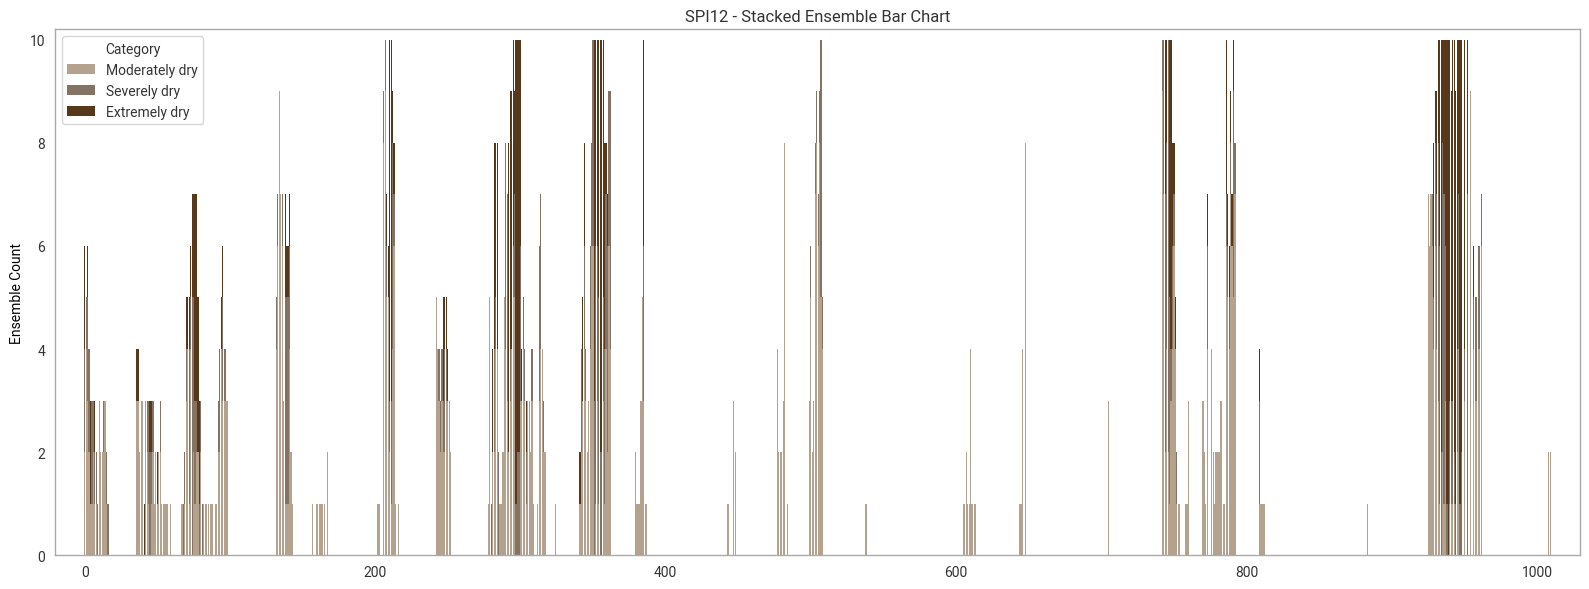

In [90]:
bottom = np.zeros(len(counts_per_timestamp))
num_timestamps = len(unique_vals)
x = da_cat["time"].values

plt.figure(figsize=(16, 6))

color_map = {
    6: "#B4A18E",   # Moderate
    7: "#847363",   # Severe
    8: "#57381A",   # Extreme
}

for i , (t, cat_arr, count_arr) in enumerate(zip(x , filtered_cats, filtered_counts)):
    bottom = 0
    for cat, cnt in zip(cat_arr, count_arr):
        plt.bar(i, cnt, bottom=bottom,
                color=color_map[cat], 
                label=f"{CATEGORIES_SPI[cat-1][2]}" if i == 0 else "",
                align = "center")
        bottom += cnt

plt.ylabel("Ensemble Count")
plt.title("SPI12 - Stacked Ensemble Bar Chart")
plt.legend(title="Category")
plt.grid(False)
plt.tight_layout()
plt.show()

# TODO: line plot of # of ens members that fail quality check.

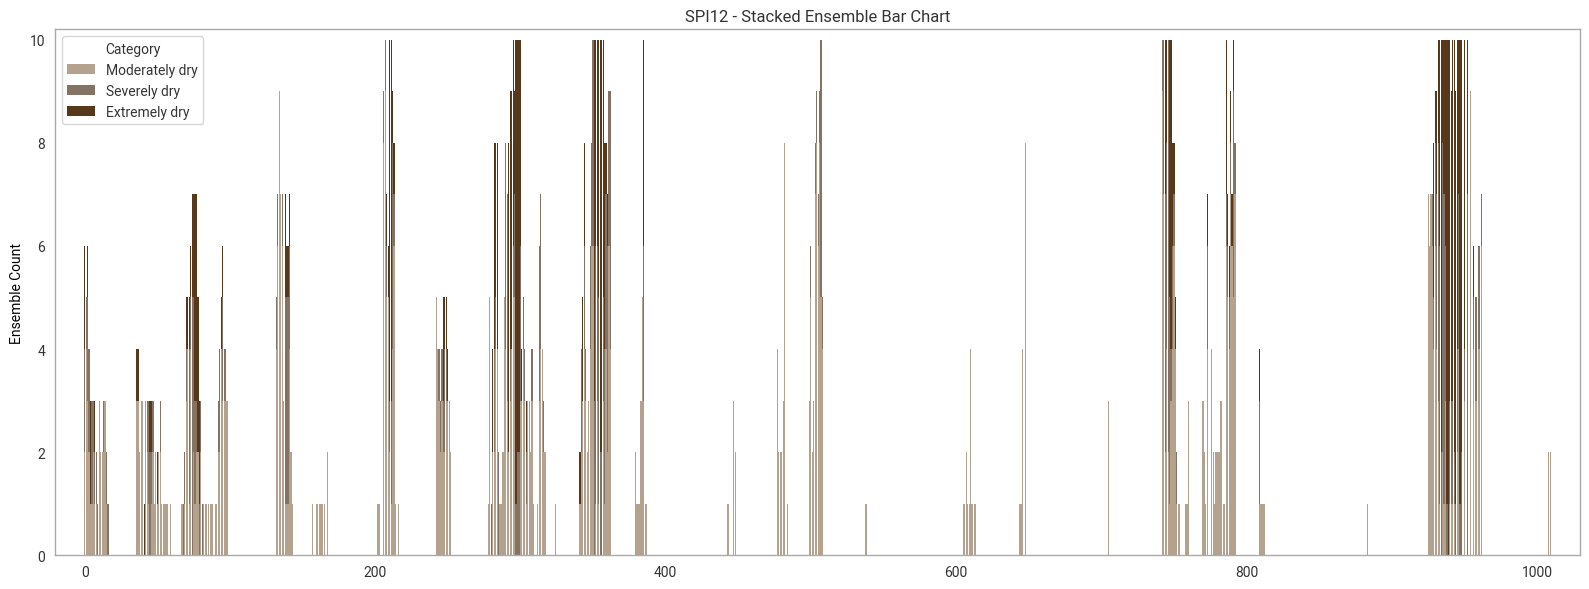

In [93]:
bottom = np.zeros(len(counts_per_timestamp))
num_timestamps = len(unique_vals)
x = range(num_timestamps)

plt.figure(figsize=(16, 6))

color_map = {
    6: "#B4A18E",   # Moderate
    7: "#847363",   # Severe
    8: "#57381A",   # Extreme
}

for i , (t, cat_arr, count_arr) in enumerate(zip(x , filtered_cats, filtered_counts)):
    bottom = 0
    for cat, cnt in zip(cat_arr, count_arr):

        if cnt == 0:
            pass
        else:
            plt.bar(i, cnt, bottom=bottom,
                    color=color_map[cat], 
                    label=f"{CATEGORIES_SPI[cat-1][2]}" if i == 0 else "",
                    align = "center")
            bottom += cnt

plt.ylabel("Ensemble Count")
plt.title("SPI12 - Stacked Ensemble Bar Chart")
plt.legend(title="Category")
plt.grid(False)
plt.tight_layout()
plt.show()

In [84]:
for i , (t, cat_arr, count_arr) in enumerate(zip(x , filtered_cats, filtered_counts)):
    print(i)
    print(t)
    print(cat_arr)
    print(count_arr)
    bottom = 0
    for cat, cnt in zip(cat_arr, count_arr):
        print(cat)
        print(cnt)
        bottom += cnt
        print(bottom)

0
1940-12-01T06:00:00.000000000
[6 7 8]
[2 2 2]
6
2
2
7
2
4
8
2
6
1
1941-01-01T06:00:00.000000000
[6 7]
[4 1]
6
4
4
7
1
5
2
1941-02-01T06:00:00.000000000
[6 7 8]
[3 2 1]
6
3
3
7
2
5
8
1
6
3
1941-03-01T06:00:00.000000000
[6 7]
[2 2]
6
2
2
7
2
4
4
1941-04-01T06:00:00.000000000
[6 8]
[1 2]
6
1
1
8
2
3
5
1941-05-01T06:00:00.000000000
[6 7]
[1 2]
6
1
1
7
2
3
6
1941-06-01T06:00:00.000000000
[6 7]
[2 1]
6
2
2
7
1
3
7
1941-07-01T06:00:00.000000000
[6 7 8]
[1 1 1]
6
1
1
7
1
2
8
1
3
8
1941-08-01T06:00:00.000000000
[6 7]
[1 1]
6
1
1
7
1
2
9
1941-09-01T06:00:00.000000000
[7]
[1]
7
1
1
10
1941-10-01T06:00:00.000000000
[6]
[3]
6
3
3
11
1941-11-01T06:00:00.000000000
[6]
[2]
6
2
2
12
1941-12-01T06:00:00.000000000
[6]
[2]
6
2
2
13
1942-01-01T06:00:00.000000000
[6 7]
[2 1]
6
2
2
7
1
3
14
1942-02-01T06:00:00.000000000
[6]
[3]
6
3
3
15
1942-03-01T06:00:00.000000000
[6 7]
[1 1]
6
1
1
7
1
2
16
1942-04-01T06:00:00.000000000
[7]
[1]
7
1
1
17
1942-05-01T06:00:00.000000000
[]
[]
18
1942-06-01T06:00:00.000000000

The mean & standard deviation (spread) for the SPI time series in the example site is then computed and plotted.

In [ ]:
def plot_index_mean_with_spread(mean_da: xr.DataArray, spread_da: xr.DataArray,
                              title: str = "SPI-12 Mean with Shaded Spread"):

    """Plot mean SPI/SPEI time series with shaded ±(spread/2) band. Here, spread is defined as standard deviation (i.e.
    array with standard deviation between all 10 ensemble members should be computed."""

    da_lo = mean_da - (spread_da / 2)
    da_hi = mean_da + (spread_da / 2)

    plt.figure(figsize=(12, 6))

    plt.fill_between(
        mean_da["time"].values,
        da_lo.values,
        da_hi.values,
        label="±1/2 ST.D",
        alpha=0.3
    )

    mean_da.plot(label="Mean", color="black")

    plt.legend()
    plt.ylabel(mean_da.name)
    plt.ylim([-8, 8])
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

spi_da_mean = era5drought_ensemble_spi_mean['SPI12'].sel(**example_site)
spi_da_spread = era5drought_ensemble_spi_spread['SPI12'].sel(**example_site)

plot_index_mean_with_spread(spi_da_mean, spi_da_spread)

#### Ensemble SPEI time series in example site (Tibooburra, New South Wales, Australia).

In [ ]:
da = era5drought_ensemble_spei_12['SPEI12'].sel(**example_site)  # select the DataArray

plot_ens_index_timeseries(da, title = 'SPEI12 — time series for each ensemble member')

The mean & spread for the SPEI time series in the example site is then computed and plotted.

In [ ]:
era5drought_ensemble_spei_mean_12, era5drought_ensemble_spei_spread_12 = ensemble_mean_and_spread(era5drought_ensemble_spei_12)

In [ ]:
spei_da_mean = era5drought_ensemble_spei_mean['SPEI12'].sel(**example_site)
spei_da_spread = era5drought_ensemble_spei_spread['SPEI12'].sel(**example_site)

plot_index_mean_with_spread(spei_da_mean, spei_da_spread, title = 'SPEI-12 Mean with Shaded Spread"')

#### # SPI & SPEI ensemble members greater than threshold value.

In [ ]:
spi_da = era5drought_ensemble_spi['SPI12'].sel(**example_site)  # select the DataArray
spei_da = era5drought_ensemble_spei['SPEI12'].sel(**example_site)  # select the DataArray

def count_index_exceed(spi_da, spei_da, spi_threshold =  2, spei_threshold = 2.33):
    
    spi_exceeds = np.abs(spi_da) > spi_threshold # boolean xarray with all values that are "severely" wet/drier than usual.
    spei_exceeds = np.abs(spei_da) > spei_threshold # boolean xarray with all values that are "severely" wet/drier than usual.

    spi_count_per_time = spi_exceeds.sum(dim='number') # count number that exceed along the ensemble dimension.
    spei_count_per_time = spei_exceeds.sum(dim='number') # count number that exceed along the ensemble dimension.

    spi_percent_per_time = (spi_count_per_time * 100) / 10 # divide by number of ens members * 100
    spei_percent_per_time = (spei_count_per_time *100) / 10 
    
    return spi_percent_per_time, spei_percent_per_time

spi_percent_per_time, spei_percent_per_time = count_index_exceed(spi_da, spei_da)

SPI - Mean & SUOM with P( |SPI| > 2 ) in example site (Tibooburra, New South Wales, Australia).

In [ ]:
def plot_band_and_threshold_percent(percent_per_time, mean_da, spread_da, threshold,
                index_label = "SPI" , accumulation_label="12", n_members=10):


    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

    # --- Top panel: % members exceeding ---
    percent_per_time.plot(ax=ax1, color='tab:purple')
    ax1.set_title(f'% ensemble members with |{index_label}{accumulation_label}| > {threshold}')
    ax1.set_ylabel('Percent (%)')
    ax1.set_xlabel('Time')
    ax1.grid(True)

    # --- 2nd panel: Ensemble band ---
    ci = (spread_da.values/np.sqrt(10-1))/2 # confidence interval divided by two
    y = mean_da.values
    t = mean_da["time"].values
    
    ax2.fill_between(mean_da["time"].values, (y-ci), (y+ci), color='b', label='±1/2 SUOM')
    ax2.hlines(y=[-spi_threshold, spi_threshold],
               xmin=da["time"].values.min(),
               xmax=da["time"].values.max(),
               colors='r', linestyles='--', label='Extreme Wet/Dry Thresholds')
    ax2.set_title(f'Mean {index_label}{accumulation_label} vs Time with St.dev Band')
    ax2.set_xlabel('Time')
    ax2.set_ylabel(f'Mean {index_label}{accumulation_label}')
    ax2.set_ylim([-8, 8])
    ax2.legend(title=f'{accumulation_label}-month accumulation period')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
plot_band_and_threshold_percent(spi_percent_per_time, spi_da_mean, spi_da_spread, 2)

SPEI - Mean & SUOM with P( |SPEI| > 2.33 ) in example site (Tibooburra, New South Wales, Australia).

In [ ]:
plot_band_and_threshold_percent(spei_percent_per_time, spei_da_mean, spei_da_spread, 2.33)

(section-5)=
### 5. Applying the Ensemble Data

#### Importing EM-DAT.

Data for natural disasters freely available: https://public.emdat.be/data Downloaded below for Australia only.

In [ ]:
df_droughts = pd.read_excel('public_emdat_custom_request_2026-02-10_4d6d0e90-816f-47b2-b19c-9529760cde15.xlsx') 

# Fill missing months with 1 so the interval is still plottable
df_droughts["Start Month"] = df_droughts["Start Month"].fillna(1).astype(int)
df_droughts["End Month"]   = df_droughts["End Month"].fillna(12).astype(int)

df_droughts["start_ts"] = pd.to_datetime(
    df_droughts["Start Year"].astype(int).astype(str) + "-" +
    df_droughts["Start Month"].astype(str) + "-01"
)

df_droughts["start_ts"] = pd.to_datetime(
    df_droughts["Start Year"].astype(int).astype(str)
    + "-"
    + df_droughts["Start Month"].astype(str)
    + "-01"
)

df_droughts["end_ts"] = pd.to_datetime(
    df_droughts["End Year"].astype(int).astype(str)
    + "-"
    + df_droughts["End Month"].astype(str)
    + "-01" )


#### Area mask for Australia
ADMIN regions were downloaded from: https://www.naturalearthdata.com/downloads/

In [ ]:
area_2d = calculate_gridarea(LAND.lat, res=abs(LAND.lat[1]-LAND.lat[0]), nlon=len(LAND.lon))*LAND
area_2d = xr.DataArray(area_2d, coords={'lat': LAND.lat,'lon': LAND.lon}, dims=["lat", "lon"])
#area_2d.plot()

In [ ]:
adminid     = "AU1"
geoshp = gpd.read_file('ne_10m_admin_0_countries_lakes.shp')
adminshpa = geoshp.loc[ (geoshp.SOV_A3 == adminid), 'geometry' ]
adminshpa=adminshpa.to_crs('EPSG:4326')
adminshpa = adminshpa.union_all()
# 5. Wrap into a clean GeoDataFrame with index = 0
adminshpa = gpd.GeoDataFrame(
    {"name": ["Australia"], "geometry": [adminshpa]},
    crs="EPSG:4326"
)

adminmask = regionmask.mask_geopandas(adminshpa, era5drought_ensemble_spi_mean.lon, era5drought_ensemble_spi_mean.lat)
adminmask_xr = xr.DataArray(adminmask, coords={'lat': era5drought_ensemble_spi_mean.lat, 'lon': era5drought_ensemble_spi_mean.lon}, dims=["lat", "lon"])
adminmask_xr = adminmask_xr.where( np.isnan(adminmask_xr.values), 1) # to set the 0 from regionmask to 1
adminmask_3d_xr = adminmask_xr.expand_dims(dim={"time": era5drought_ensemble_spi_mean.time}, axis=0)

Again the mean, standard deviation (spread) for the ensemble SPI are calculated across all Australia

In [ ]:
era5drought_ensemble_spi_mean, era5drought_ensemble_spi_spread = ensemble_mean_and_spread(era5drought_ensemble_spi_aus)

In [ ]:
# calculate area in drought, over all ensemble members.
area_2d_adj = area_2d * LAND_FRAC

area_2d_adj = area_2d_adj.reindex(lat=era5drought_ensemble_spi_aus.lat,lon=era5drought_ensemble_spi_aus.lon, method="nearest")
area_2d_adj = area_2d_adj.drop_vars(["number", "expver","time"])
area_3d_adj = area_2d_adj.expand_dims(time = era5drought_ensemble_spi_aus.time, number =era5drought_ensemble_spi_aus.number )

mean_aid_spi = {}
std_aid_spi = {}

window = 12
swindow=f"w{window}"
mean_aid_spi[swindow] = {}
std_aid_spi[swindow] = {}

mylevels     = [-10000,-1000,-2,-1.5,-1,1,1.5,2,1000]
mycollisthex = ['#bebebe','#663300','#8c6640','#b29980','#ffffff','#99b280','#668c40','#336600']

for severity in ['moderate','severe','extreme','any']:

    if severity == "mild":
        thresh_min, thresh_max = -1, 0
    elif severity == "moderate":
        thresh_min, thresh_max = -1.5, -1
    elif severity == "severe":
        thresh_min, thresh_max = -2, -1.5
    elif severity == "extreme":
        thresh_min, thresh_max = -999, -2
    elif severity == "any":
        thresh_min, thresh_max = -999, -1

    # pre‑compute drought mask
    rspi  = era5drought_ensemble_spi_aus["SPI12"] * adminmask_3d_xr
    dmask = xr.where((rspi > thresh_min) & (rspi <= thresh_max) & (rspi != -9999),
                     1, np.nan)

    # pre‑compute denominators once for all ensemble members
    denom = (adminmask_3d_xr * area_3d_adj).sum(["lat", "lon"])

    # compute numerators vectorized
    num   = (dmask * area_3d_adj).sum(["lat", "lon"])

    # drought % for all ensemble members at once
    result = 100 * num / denom   # shape: (number,)

    std_result = result.std(dim="number")
    mean_result = result.mean(dim="number")
    
    mean_aid_spi[swindow][severity] = mean_result.to_pandas() 
    std_aid_spi[swindow][severity] = std_result.to_pandas()

In [ ]:
# --- FIGURE SETUP ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4), sharex=True)

title1 = r"$\bf{" + f"{string.ascii_lowercase[0]}" + "}$"
fig.suptitle(
    f"{title1} | Percent of Australia in drought (SPI-{window}) over ensemble members.",
    fontsize=18, y=0.97
)

plt.rc('font', family='sans-serif', weight='normal', size=16)

severities = ['extreme', 'severe', 'moderate']

mean_apidata = pd.concat([
    mean_aid_spi[f'w{window}']['extreme'],
    mean_aid_spi[f'w{window}']['severe'],
    mean_aid_spi[f'w{window}']['moderate']
], axis=1)

std_apidata = pd.concat([
    std_aid_spi[f'w{window}']['extreme'],
    std_aid_spi[f'w{window}']['severe'],
    std_aid_spi[f'w{window}']['moderate']
], axis=1)


# --- APPLY TO SUBPLOTS ----------------------------------------------------

handles1 = plot_stacked(ax1, mean_apidata, "Mean [%]")
handles2 = plot_stacked(ax2, std_apidata, "Stdev. [%]")

# --- SHARED LEGEND --------------------------------------------------------

fig.legend(
    handles1,
    severities,
    title="Drought Severity",
    title_fontsize=12,
    ncol=len(severities),
    loc="lower center",
    bbox_to_anchor=(0.5, 0.3),
    frameon=False,
)

# Ensure index is integer years
drought_years = dr_cnt.index.astype(int).tolist()

for _, row in df_droughts.iterrows():
    ax1.axvspan(row["start_ts"], row["end_ts"], color="red", alpha=0.15, lw=0)
    ax2.axvspan(row["start_ts"], row["end_ts"], color="red", alpha=0.15, lw=0)

plt.show() # TODO - Same plot with SPI1 and compare. What different information do they provide?

## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

List the references used in the Notebook here.

E.g.

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.